In [1]:
import numpy as np
import librosa
import glob
import os
from random import randint
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [2]:
torch.cuda.set_device(3)
print(torch.cuda.current_device())

3


In [3]:
class TripletLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.siamese_cnn = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=[4,128],stride=[1,128]),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=[4,1],stride=[1,1]),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=[4,1],stride=[1,1]),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        #max_pool 注意保证padding="same"
        self.late_cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=[3,3],stride=[1,1]),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[3,3],stride=[3,3],padding=1),

            nn.Conv2d(64, 128, kernel_size=[3,3],stride=[1,1]),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[3,3],stride=[3,3],padding=[1,0]),

            nn.Conv2d(128, 256, kernel_size=[3,3],stride=[1,1]),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.rnnLSTM = nn.LSTM(
            input_size=256, 
            hidden_size=128,
            num_layers=2,
            dropout=0.1,
            batch_first=True,
            bidirectional=True,
            )
        self.fcWithDropout = nn.Sequential(
            nn.Linear(256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 2),
            nn.Softmax(dim=1),
            )
        
    def cal_similarity(self,matrix1,matrix2):
        #out1.shape = torch.Size([10, 256, 336])
        out1 = torch.squeeze(matrix1,dim=3)
        out2 = torch.squeeze(matrix2,dim=3)
        #num.shape = torch.Size([10, 336, 336])
        num = torch.bmm(torch.transpose(out1,1,2),out2)
        h1_norm = torch.sqrt(torch.sum(torch.mul(out1,out1), dim=1, keepdim=True))
        h2_norm = torch.sqrt(torch.sum(torch.mul(out2,out2), dim=1, keepdim=True))
        #denom torch.Size([10, 336, 336])
        denom = torch.bmm(torch.transpose(h1_norm,1,2),h2_norm)
        #fms shape torch.Size([10, 1, 336, 336])
        fms = torch.unsqueeze(torch.div(num,denom),dim=1)
        return fms
    
    def _reduce_var(self,inputs):
        m1 = torch.mean(inputs,dim=2,keepdim=True)
        m = torch.mean(m1,dim=3,keepdim=True)
        devs_squared1 = torch.mul(inputs - m,inputs - m)
        #not keep dim
        devs_squared2 = torch.mean(devs_squared1,dim=2)
        devs_squared = torch.mean(devs_squared2,dim=2)
        return devs_squared
    
    def cal_global_pool(self,matrix):
        # not keep dim
        g_max1,_ = torch.max(matrix,dim=2)
        g_max,_ = torch.max(g_max1,dim=2)
        g_mean1 = torch.mean(matrix,dim=2)
        g_mean = torch.mean(g_mean1,dim=2)
        g_var = self._reduce_var(matrix)
        return torch.cat([g_max, g_mean, g_var], 1)
    
    def cal_lstm(self,seqInput):
        #view batchsize seq-length input-size
        #dataParaller may change the batchsize
        lstm_batchSize = list(seqInput.size())[0]
        seqInput = seqInput.view(lstm_batchSize,3,-1)
        outLstm,(_,_) = self.rnnLSTM(seqInput)
        return outLstm[:,-1,:]
        
    def forward(self,x1,x2,x3):
        out1 = self.siamese_cnn(x1)
        out2 = self.siamese_cnn(x2)
        out3 = self.siamese_cnn(x2)
        out4 = self.siamese_cnn(x3)
        similarity1 = self.cal_similarity(out1,out2)
        similarity2 = self.cal_similarity(out3,out4)
        late_cnn_out = self.late_cnn((similarity1 + similarity2)/2)
        golbal_pool_out = self.cal_global_pool(late_cnn_out)
        lstmout = self.cal_lstm(golbal_pool_out)
        predictions = self.fcWithDropout(lstmout)
        return predictions  

In [5]:
tripleNet_LSTM_model = TripletLSTM().double().cuda()
state_dict = torch.load('../model/tripleNet_LSTM.pkl',map_location={'cuda:0':'cuda:3'})
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v
tripleNet_LSTM_model.load_state_dict(new_state_dict)
tripleNet_LSTM_model = tripleNet_LSTM_model.eval()

In [6]:
lstm_data = []
sample =1000
for song_num in range(sample):
    token_train = "song{}_1,song{}_2,song{}_3".format(song_num,song_num,song_num,song_num)
    lstm_data.append(token_train)
    
    token_train = "song{}_1,song{}_3,song{}_2".format(song_num,song_num,song_num,song_num)
    lstm_data.append(token_train)
    
    token_train = "song{}_2,song{}_1,song{}_3".format(song_num,song_num,song_num,song_num)
    lstm_data.append(token_train)

    token_train = "song{}_2,song{}_3,song{}_1".format(song_num,song_num,song_num,song_num)
    lstm_data.append(token_train)
    
    token_train = "song{}_3,song{}_1,song{}_2".format(song_num,song_num,song_num,song_num)
    lstm_data.append(token_train)
    
    token_train = "song{}_3,song{}_2,song{}_1".format(song_num,song_num,song_num,song_num)
    lstm_data.append(token_train)

In [16]:
data_dir = "/media/data/cuixuange/ScrawlMusic/train_data_normalizatin/"
def load_exits_file(train_data,index):
    str_data = train_data[index].split(",")      
    x1_name = data_dir + str_data[0]+".npy"
    x2_name = data_dir + str_data[1]+".npy"
    x3_name = data_dir + str_data[2]+".npy"
    if os.path.isfile(x1_name) and os.path.isfile(x2_name) and os.path.isfile(x3_name): 
        return x1_name,x2_name,x3_name,index
    else:
        index += randint(6,9)
        return load_exits_file(train_data,index)

In [17]:
with torch.no_grad():
    def cal_similarity(matrix1,matrix2):
        out1 = torch.squeeze(matrix1,dim=3)
        out2 = torch.squeeze(matrix2,dim=3)
        num = torch.bmm(torch.transpose(out1,1,2),out2)
        h1_norm = torch.sqrt(torch.sum(torch.mul(out1,out1), dim=1, keepdim=True))
        h2_norm = torch.sqrt(torch.sum(torch.mul(out2,out2), dim=1, keepdim=True))
        denom = torch.bmm(torch.transpose(h1_norm,1,2),h2_norm)
        fms = torch.unsqueeze(torch.div(num,denom),dim=1)
        return fms

    def _reduce_var(inputs):
        m1 = torch.mean(inputs,dim=2,keepdim=True)
        m = torch.mean(m1,dim=3,keepdim=True)
        devs_squared1 = torch.mul(inputs - m,inputs - m)
        devs_squared2 = torch.mean(devs_squared1,dim=2)
        devs_squared = torch.mean(devs_squared2,dim=2)
        return devs_squared

    def cal_global_pool(matrix):
        g_max1,_ = torch.max(matrix,dim=2)
        g_max,_ = torch.max(g_max1,dim=2)
        g_mean1 = torch.mean(matrix,dim=2)
        g_mean = torch.mean(g_mean1,dim=2)
        g_var = _reduce_var(matrix)
        return torch.cat([g_max, g_mean, g_var], 1)

    def cal_lstm(module,seqInput):
        #view batchsize seq-length input-size
        #dataParaller may change the batchsize
        lstm_batchSize = list(seqInput.size())[0]
        seqInput = seqInput.view(lstm_batchSize,3,-1)
        outLstm,(_,_) = module(seqInput)
        return outLstm[:,-1,:]
    
    def getLinearLayer(x1,x2,x3):
        for name, module in tripleNet_LSTM_model._modules.items():
            module = module.cuda()
            if(name == "siamese_cnn"):
                x1 = module(x1)
                x2 = module(x2)
                x3 = module(x3)
                sim1 = cal_similarity(x1,x2)
                sim2 = cal_similarity(x2,x3)
            if(name == "late_cnn"):
                late_cnn_out = module((sim1 + sim2)/2)
                golbal_pool_out = cal_global_pool(late_cnn_out)
            if(name == "rnnLSTM"):
                lstmout = cal_lstm(module,golbal_pool_out)
            if(name == "fcWithDropout"):
                layer_out = module[0](lstmout)
                for i in range(1,8):
                    layer_out = module[i](layer_out)
                return layer_out

    x1_name,x2_name,x3_name,exit_index = load_exits_file(lstm_data,0)
    x1 = torch.from_numpy(np.load(x1_name)).unsqueeze(0).unsqueeze(0).cuda()
    x2 = torch.from_numpy(np.load(x2_name)).unsqueeze(0).unsqueeze(0).cuda()
    x3 = torch.from_numpy(np.load(x3_name)).unsqueeze(0).unsqueeze(0).cuda()
    layer_out = getLinearLayer(x1,x2,x3)
    print(layer_out.shape)

print(layer_out[0])

torch.Size([1, 1024])
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:3', dtype=torch.float64)


In [18]:
sample = 5000

X_embedded = np.zeros((sample,1024))
Y_embedded = []
print(X_embedded.shape)


def getPart(data):
    p1 = data.split(",")[0][-1]
    p2 = data.split(",")[1][-1]
    p3 = data.split(",")[2][-1]
    return "P{}P{}P{}".format(p1,p2,p3)

for i in range(sample):
    Y_embedded.append(getPart(lstm_data[i]))


with torch.no_grad():
    for key,token in enumerate(lstm_data):
        x1_name,x2_name,x3_name,exit_index = load_exits_file(lstm_data,key)
        x1 = torch.from_numpy(np.load(x1_name)).unsqueeze(0).unsqueeze(0).cuda()
        x2 = torch.from_numpy(np.load(x2_name)).unsqueeze(0).unsqueeze(0).cuda()
        x3 = torch.from_numpy(np.load(x3_name)).unsqueeze(0).unsqueeze(0).cuda()

        predict_label = getLinearLayer(x1,x2,x3).detach().cpu().numpy()
        X_embedded[key] = predict_label
        if(key==sample-1):
            break

  

(5000, 1024)


In [25]:
np.save("./TSN-R_feature.npy",X_embedded)

In [23]:

import time
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca_50 = PCA(n_components=20)
X_embedded_PCA = pca_50.fit_transform(X_embedded)
print("50个主要组成部分的累积解释变异: {}".format(np.sum(pca_50.explained_variance_ratio_)))


tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
X_embedded2  = tsne.fit_transform(X_embedded_PCA)
print(X_embedded2.shape)


df_new = pd.DataFrame(X_embedded2,columns=["x_tsne","y_tsne"])
df_new["label"] = Y_embedded


print(df_new.head(5))

50个主要组成部分的累积解释变异: 0.9984076364820237
(5000, 2)
      x_tsne     y_tsne   label
0 -68.613441  10.314517  P1P2P3
1  36.999172  41.301559  P1P3P2
2  -2.257225  33.688828  P2P1P3
3  39.892815  42.520988  P2P3P1
4  43.114178  35.081261  P3P1P2


(834, 3) (833, 3) (1667, 3)
       x_tsne     y_tsne   label
0  -68.613441  10.314517  P1P2P3
6    3.897883  32.334145  P1P2P3
12 -77.398575  10.194188  P1P2P3
18 -52.512421 -18.936375  P1P2P3
24 -43.610096  27.378763  P1P2P3
       x_tsne     y_tsne   label
11   6.826825  29.103146  P3P2P1
19 -53.118835 -32.546616  P1P3P2
20 -51.588814 -33.994801  P2P1P3
35   3.835606  70.703239  P3P2P1
43  -3.457014  70.333504  P1P3P2
         x_tsne     y_tsne   label
4985 -42.094120 -41.312515  P3P2P1
4987 -15.848635 -27.035915  P1P3P2
4989 -17.555916 -46.070709  P2P3P1
4990  10.149019  -3.805550  P3P1P2
4996   0.943914 -36.237103  P3P1P2


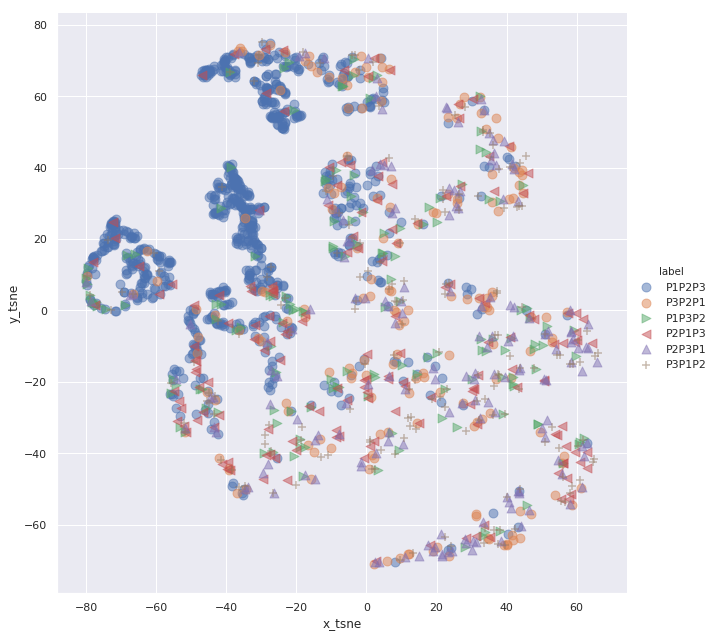

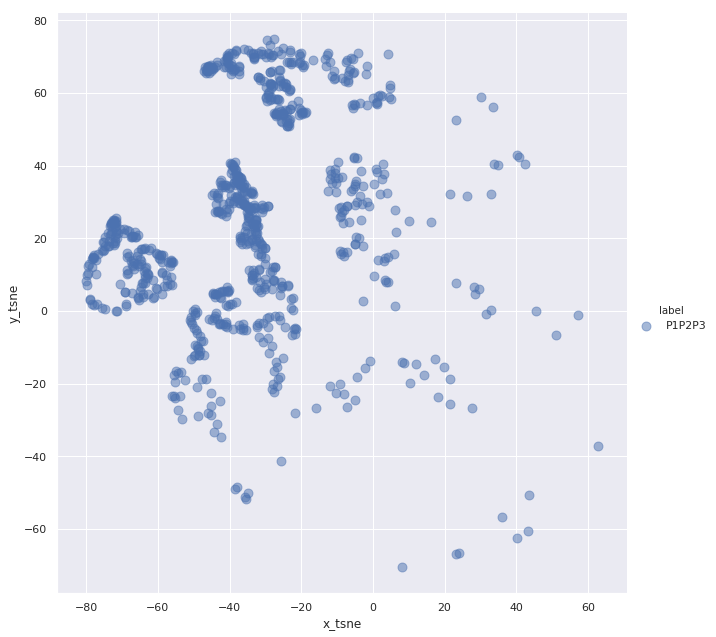

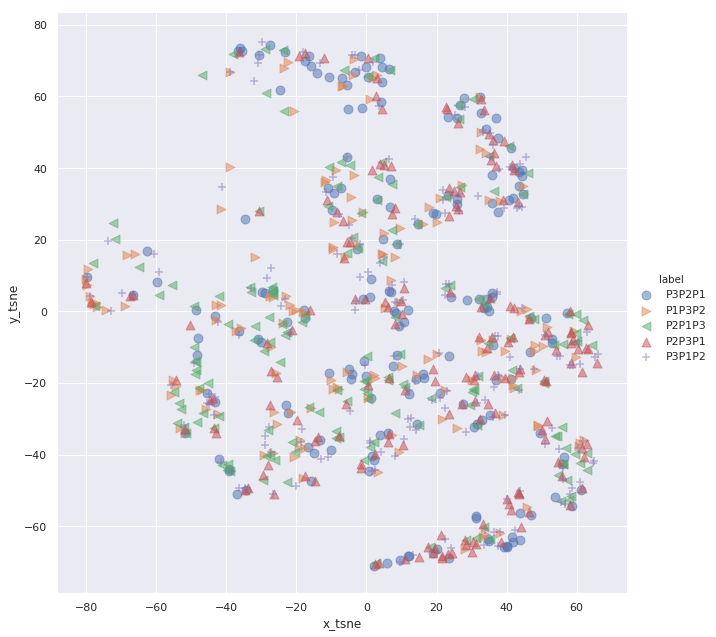

In [24]:
sns.set()
# print(df_new.head(5))

# Z_embedded = []
# for i in range(sample):
#     if(X_embedded[i][0] > X_embedded[i][1]):
#         Z_embedded.append("P")
#     else:
#         Z_embedded.append("N")

df_new1 = df_new.loc[(df_new['label'] == "P1P2P3")]
df_new2 = df_new.loc[(df_new['label'] != "P1P2P3")]
msk = np.random.rand(len(df_new2)) < 0.2
df_new2 = df_new2[msk]

df_new3 = df_new1.append(df_new2)
print(df_new1.shape,df_new2.shape,df_new3.shape)
print(df_new1.head(5))
print(df_new2.head(5))
print(df_new3.tail(5))


# mydict = {"1_2_3":"b", "1_3_2":"y","2_1_3":"g","2_3_1":"r","3_1_2":"m","3_2_1":"b"}
markers=["o", "o", ">","<","^","+"]
sns.lmplot(x='x_tsne',
           y='y_tsne',
           data=df_new3,
           fit_reg=False,
           legend=True,
           truncate=True,
           markers=markers,
           height=9,
           hue='label',
#            palette=mydict,
           scatter_kws={"s":80, "alpha":0.5})

df_new4 = df_new3.loc[(df_new3['label'] == "P1P2P3")]
sns.lmplot(x='x_tsne',
           y='y_tsne',
           data=df_new4,
           fit_reg=False,
           legend=True,
           truncate=True,
#            markers=markers,
           height=9,
           hue='label',
#            palette=mydict,
           scatter_kws={"s":80, "alpha":0.5})

markers=["o", ">","<","^","+"]
df_new5 = df_new3.loc[(df_new3['label'] != "P1P2P3")]
sns.lmplot(x='x_tsne',
           y='y_tsne',
           data=df_new5,
           fit_reg=False,
           legend=True,
           truncate=True,
           markers=markers,
           height=9,
           hue='label',
#            palette=mydict,
           scatter_kws={"s":80, "alpha":0.5})


In [26]:
with open("./tsn-R_Y_embedded.txt","w") as file:
    for i in Y_embedded:
        file.write(i+"\n")